In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.autonotebook import tqdm

/tmp/ipykernel_3379079/2687531021.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Unzip the 9_way and 100_way dataset

In [2]:
import zipfile
with zipfile.ZipFile("/home/jliu/ttmp/PBSCSR/9_way_dataset.zip", 'r') as f:
    f.extractall("../")

with zipfile.ZipFile("/home/jliu/ttmp/PBSCSR/100_way_dataset.zip", 'r') as f:
    f.extractall("../")

Load the corresponding dataset.pkl for 9_way dataset or 100_way dataset

In [3]:
# with open("../9_way_dataset.pkl", "rb") as f:
with open("../100_way_dataset.pkl", "rb") as f:
    x_train, y_train, x_valid, y_valid, x_test, y_test, m_train, m_valid, m_test = pickle.load(f)

In [4]:
composers = np.unique(y_train).tolist()
y_train = torch.Tensor([composers.index(i) for i in y_train]).long()
y_valid = torch.Tensor([composers.index(i) for i in y_valid]).long()
y_test = torch.Tensor([composers.index(i) for i in y_test]).long()
print(y_train)

tensor([15,  9, 79,  ..., 61,  6, 77])


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.main = nn.Sequential(
			# Convolve once (1, 64, 62) -> (16, 30, 29)
            nn.Conv2d(1, 16, kernel_size=(5, 5)),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
			
            # Convolve twice (16, 30, 29) -> (8, 13, 12)
			nn.Conv2d(16, 8, kernel_size=(5, 5)),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
			
            # Fully connected
            nn.Flatten(),
            # nn.Linear(12*13*8, 9) for 9_ways data
            # nn.Linear(12*13*8, 100) for 100_ways data
			nn.Linear(12 * 13 * 8, 100),
        )
	
    def forward(self, x):
        # Make sure its a tensor and add a "channel" dim
        x = torch.Tensor(x).unsqueeze(-3)
        return self.main(x)

In [6]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [7]:
BATCH_SIZE = 32
EPOCHS = 8

losses = []
accs = []

valid_losses = []
valid_accs = []

for epoch in range(EPOCHS):
    for batch in tqdm(range(0, len(x_train), BATCH_SIZE)):
        x_batch = x_train[batch:batch+BATCH_SIZE]
        y_batch = y_train[batch:batch+BATCH_SIZE]

        optimizer.zero_grad()

        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        acc = (y_batch == y_pred.argmax(-1)).float().mean()
        loss.backward()

        valid_batch = torch.randint(len(x_valid), size=(BATCH_SIZE,)).long()
        # print(valid_batch)
        x_valid_batch = x_valid[valid_batch]
        y_valid_batch = y_valid[valid_batch]

        y_valid_pred = model(x_valid_batch)
        valid_loss = criterion(y_valid_pred, y_valid_batch)
        valid_acc = (y_valid_batch == y_valid_pred.argmax(-1)).float().mean()

        losses.append(loss.item())
        accs.append(acc.item())
        
        valid_losses.append(valid_loss.item())
        valid_accs.append(valid_acc.item())

        optimizer.step()

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

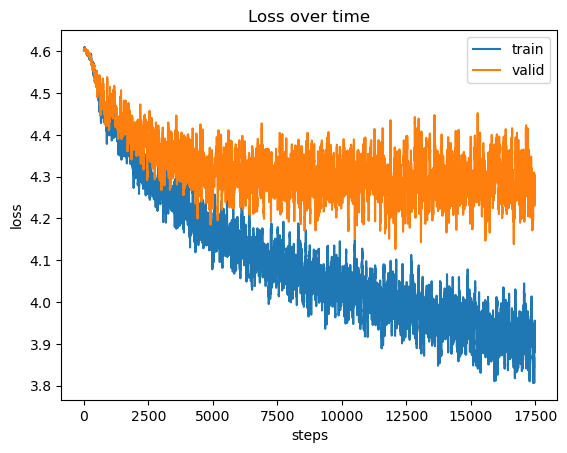

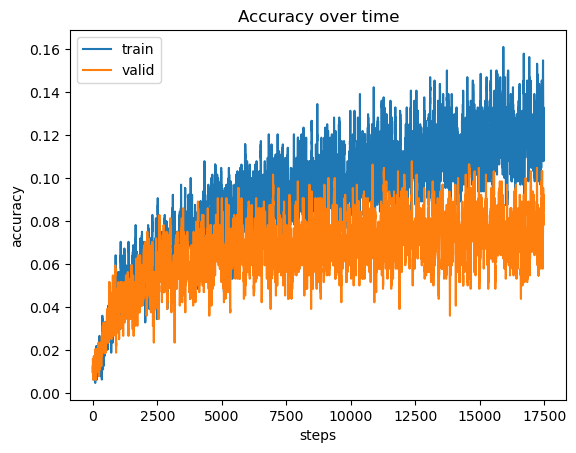

In [8]:
window = 20

plt.plot([np.mean(losses[i:i+window]) for i in range(len(losses)-window)], label="train")
plt.plot([np.mean(valid_losses[i:i+window]) for i in range(len(valid_losses)-window)], label="valid")
plt.title("Loss over time")
plt.ylabel("loss")
plt.xlabel("steps")
plt.legend()
plt.show()

plt.plot([np.mean(accs[i:i+window]) for i in range(len(accs)-window)], label="train")
plt.plot([np.mean(valid_accs[i:i+window]) for i in range(len(valid_accs)-window)], label="valid")
plt.title("Accuracy over time")
plt.ylabel("accuracy")
plt.xlabel("steps")
plt.legend()
plt.show()

In [9]:
def top_x_acc(y_true, y_pred, x):
    ranked = torch.argsort(y_pred, axis=-1)
    top_x = ranked[..., -x:]
    # print(ranked.shape)
    return (top_x == torch.repeat_interleave(y_true.unsqueeze(-1), x, axis=-1)).float().sum(-1).mean().item()

def mean_recip_rank(y_true, y_pred):
    ranked = torch.argsort(y_pred, axis=-1)
    
    # print(ranked.shape, torch.repeat_interleave(y_true.unsqueeze(-1), y_true.shape[-1], axis=-1).shape)

    # starts with worst at 0 but we want best at 1 so
    true_ranks = y_pred.shape[-1] - (ranked == torch.repeat_interleave(y_true.unsqueeze(-1), y_pred.shape[-1], axis=-1)).float().argmax(-1)

    return (1/true_ranks).mean().item()

In [10]:
y_pred = model(x_test)

loss = criterion(y_pred, y_test)
acc = (y_test == y_pred.argmax(-1)).float().mean()

#print("Final Test Loss:", loss.item())
print("Final Test Top-1 Accuracy", top_x_acc(y_test, y_pred, 1))
print("Final Test Top-5 Accuracy", top_x_acc(y_test, y_pred, 5))

# comment out top-10 statement if doing 9_way_dataset.
print("Final Test Top-10 Accuracy", top_x_acc(y_test, y_pred, 10))
print("Mean Reciprocal Rank", mean_recip_rank(y_test, y_pred))

Final Test Top-1 Accuracy 0.07000000029802322
Final Test Top-5 Accuracy 0.21533332765102386
Final Test Top-10 Accuracy 0.32839998602867126
Mean Reciprocal Rank 0.15849870443344116
